HLS4ML


In [1]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import hls4ml
from tensorflow import keras
import qkeras
import plotting

2024-08-07 23:44:10.913817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 23:44:10.913870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 23:44:10.921019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 23:44:10.975017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 23:44:12.153881: W tensorflow/compiler/tf2

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/home/berkb/miniconda3/envs/qkeras/lib/python3.9/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [7]:
f.close()

In [2]:
#Samples are represented in 16-bit 2's complement
signalList = []
# Get the directory where the script is located
script_dir = os.getcwd()
# Construct the full path to the file
file_path = os.path.join(script_dir, 'EDF', 'PD patient Frontal', 'DP141.edf')
f = pyedflib.EdfReader(file_path)
number_of_samples = f.getNSamples()[0]
data_samples=(426-380)*250
freq = f.getSampleFrequencies()
Nblocks = int((data_samples)/64)
signal_labels = f.getSignalLabels()
n = f.signals_in_file
n=n-9
X=np.ndarray(shape=(n, data_samples))
sigbufs = np.zeros(number_of_samples)
full_data64 = np.ndarray(shape=(n, Nblocks, 64, 1))
multiplier = f.getPhysicalMaximum(0)/f.getDigitalMaximum(0)
for i in range(n):
        sigbufs[:] = f.readSignal(i, digital=True)
        sigbufs_new = sigbufs[380*250:426*250]
        X[i] = sigbufs_new*multiplier
        signalList.append(sigbufs_new) 
        for j in range(Nblocks):
                full_data64[i][j] = signalList[i][j*64:(j+1)*64].reshape(64, 1)
print(full_data64.shape)
print(f.getSignalLabels()[17])
f.close()

(21, 179, 64, 1)
EEG C4-AV


In [3]:
def prd_loss_dig2phy(y_true, y_pred):
    y_true = (y_true)*multiplier
    y_pred = (y_pred)*multiplier
    rms_deviation = (tf.reduce_sum(tf.square(y_true - y_pred)))
    percentage_rmsd = tf.sqrt(rms_deviation/(tf.reduce_sum(tf.square(y_true))+tf.keras.backend.epsilon()))* 100
    return percentage_rmsd

In [4]:
import tensorflow.keras.backend as K

def weighted_mse_loss(y_true, y_pred):
    # y_true, y_pred shape: (batch_size, num_channels, signal_length)
    # label shape: (batch_size, )
    weight = 150
    # Extract the labels (0 or 1) from the last dimension of y_true
    labels = y_true[:, :, 1]
    # Remove the labels from y_true for loss calculation
    y_true_processed = y_true[:, :, 0]
    y_true_processed=y_true_processed[..., tf.newaxis]
    loss = K.mean(K.square(y_pred - y_true_processed))
    weighted_loss = loss * ((labels * (weight - 1)) + 1)
    return K.mean(weighted_loss)

In [5]:
def prd_loss_dig2phy_new(y_true, y_pred):
    y_true_processed = y_true[:, :, 0]
    y_true_processed = y_true_processed[..., tf.newaxis]
    y_true_processed = (y_true_processed)*multiplier
    y_pred = (y_pred)*multiplier
    rms_deviation = (tf.reduce_sum(tf.square(y_true_processed - y_pred)))
    percentage_rmsd = tf.sqrt(rms_deviation/(tf.reduce_sum(tf.square(y_true_processed))+tf.keras.backend.epsilon()))* 100
    return percentage_rmsd

In [7]:
import hls4ml.model
import hls4ml.model.optimizer
from qkeras.utils import load_qmodel
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
best_autoencoder = load_qmodel('real_quantised.h5', custom_objects={'prd_loss_dig2phy_new': prd_loss_dig2phy_new, 'weighted_mse_loss': weighted_mse_loss})
seizureLosses = np.ndarray(shape= (21, 1))
normalLosses = np.ndarray(shape= (21, 1))
pred = np.ndarray(shape=(n, Nblocks, 64, 1))
inter = np.ndarray(shape=(n, Nblocks, 16))
weight_model = load_qmodel('inter1_quantised.h5', custom_objects={'prd_loss_dig2phy_new': prd_loss_dig2phy_new, 'weighted_mse_loss': weighted_mse_loss})
best_autoencoder.set_weights(weight_model.get_weights())
Qencoder = best_autoencoder.layers[1]
decoder = best_autoencoder.layers[2]
config = hls4ml.utils.config_from_keras_model(Qencoder, granularity='name')
config['Model']['Precision'] = 'ap_fixed<28, 16, AP_RND_ZERO, AP_SAT>'
config['Model']['ReuseFactor'] = 2
config['Model']['Strategy'] = 'Resource'
# Iterate through each layer in the config dictionary
for layer in config['LayerName']:
    # Set the 'result' precision to 'ap_int<32,16>'
    if layer == 'q_activation_24':
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<16, 16, AP_RND_ZERO, AP_SAT>'
        config['LayerName'][layer]['Strategy'] = 'Stable'
    else:
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<28, 16, AP_RND_ZERO, AP_SAT>'
        config['LayerName'][layer]['Precision']['Bias'] = 'ap_fixed<12, 1, AP_RND_ZERO, AP_SAT>'
        config['LayerName'][layer]['Precision']['Weight'] = 'ap_fixed<12, 1, AP_RND_ZERO, AP_SAT>'
config['LayerName']['input_time_series']['Precision']['result'] = 'ap_int<16>'
# config['Flows'] = ['vivado:fifo_depth_optimization']
# hls4ml.model.optimizer.get_optimizer('vivado:fifo_depth_optimization').configure(profiling_fifo_depth=100_000)
#plotting.print_dict(config)
inter = Qencoder.predict(full_data64[17])
np.save('inputData.npy', full_data64[17])
np.save('outputData.npy', inter)
cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['ProjectName'] = 'Encoder'
cfg['HLSConfig'] = config
cfg['KerasModel'] = Qencoder
cfg['OutputDir'] = 'model_2/hls4ml_prj'
cfg['XilinxPart'] = 'xcvu13p-flga2577-2-e'
cfg['ClockPeriod'] = 10
cfg['InputData'] = 'inputData.npy'
cfg['OutputData'] = 'outputData.npy'
hls_model = hls4ml.converters.keras_to_hls(cfg)

plotting.print_dict(cfg)
# hls_model = hls4ml.converters.convert_from_keras_model(
#      Qencoder, hls_config=config, output_dir='hls4ml_fifo_depth_opt', part='xcvu13p-flga2577-2-e', backend='Vivado', project_name='Qencoder', clock_period=10, io_type='io_stream',
#      input_data_tb='model_1/inputData.npy', output_data_tb='model_1/outputData.npy')
#hls_model.build(csim=True, reset=False, synth=True, cosim=True)


Interpreting Model
Topology:
Layer name: input_time_series, layer type: InputLayer, input shapes: [[None, 64, 1]], output shape: [None, 64, 1]
Layer name: q_conv1d_16, layer type: QConv1D, input shapes: [[None, 64, 1]], output shape: [None, 64, 8]
Layer name: q_activation_20, layer type: Activation, input shapes: [[None, 64, 8]], output shape: [None, 64, 8]
Layer name: q_conv1d_17, layer type: QConv1D, input shapes: [[None, 64, 8]], output shape: [None, 64, 8]
Layer name: q_activation_21, layer type: Activation, input shapes: [[None, 64, 8]], output shape: [None, 64, 8]
Layer name: q_conv1d_18, layer type: QConv1D, input shapes: [[None, 64, 8]], output shape: [None, 32, 4]
Layer name: q_activation_22, layer type: Activation, input shapes: [[None, 32, 4]], output shape: [None, 32, 4]
Layer name: q_conv1d_19, layer type: QConv1D, input shapes: [[None, 32, 4]], output shape: [None, 16, 4]
Layer name: q_activation_23, layer type: Activation, input shapes: [[None, 16, 4]], output shape: [No

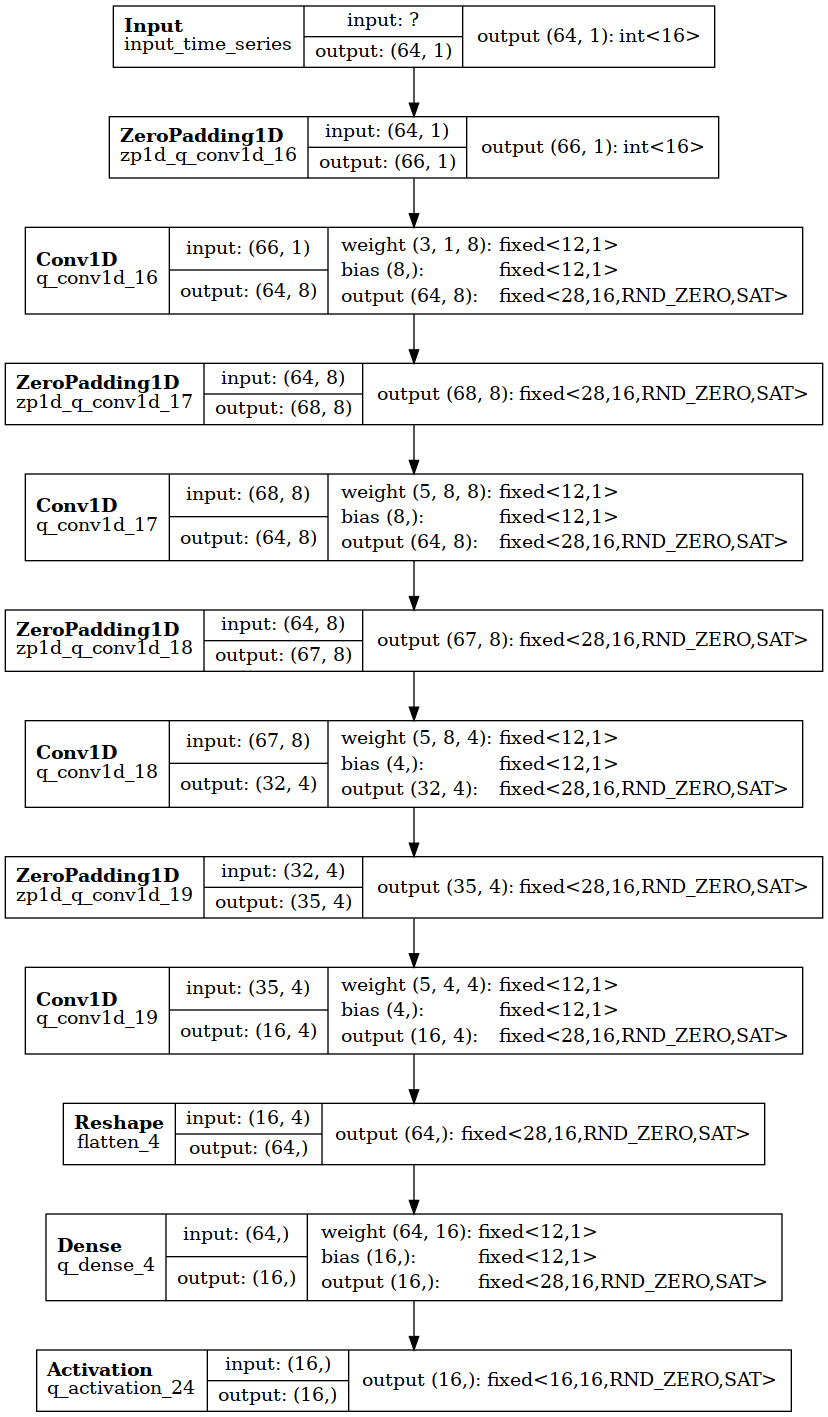

In [8]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [9]:
hls_model.compile()
interQkeras = np.ndarray(shape=(n*Nblocks, 16))
interHls4ml = np.ndarray(shape=(n*Nblocks, 16))
interQkeras = Qencoder.predict(full_data64.reshape(n*Nblocks, 64, 1))
interHls4ml = hls_model.predict(full_data64.reshape(n*Nblocks, 64, 1))
diff_count = 0
for index in np.arange(Nblocks*n):
    sameOrnot = np.array_equal(interQkeras[index], interHls4ml[index])
    if sameOrnot == False:
        print(index)
        diff_count += np.sum(interQkeras[index] != interHls4ml[index])
        #print(interQkeras[0,index]), print(interHls4ml[0,index])

print(diff_count)

Writing HLS project


/home/berkb/miniconda3/envs/qkeras/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


/home/berkb/miniconda3/envs/qkeras/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


118/118 [==============================] - 1s 6ms/step
83
286
325
549
863
982
1035
1109
1240
1269
1299
1342
1375
1432
1461
1465
1483
1507
1525
1530
1614
1674
1698
1702
1711
1751
1896
1981
2040
2090
2177
2229
2287
2290
2298
2355
2377
2389
2671
2707
2831
2865
2875
2988
3060
3073
3150
3225
3231
3258
3357
3377
3388
3405
3465
3593
3748
3753
59


In [10]:
out_qkeras = decoder.predict(interQkeras)
out_hls4ml = decoder.predict(interHls4ml)
print(prd_loss_dig2phy(full_data64.reshape(n*Nblocks, 64, 1), out_qkeras), prd_loss_dig2phy(full_data64.reshape(n*Nblocks, 64, 1), out_hls4ml))

118/118 [==============================] - 0s 2ms/step
tf.Tensor(18.450289204295093, shape=(), dtype=float64) tf.Tensor(18.450279403584858, shape=(), dtype=float64)


In [39]:
print(interQkeras[27]), print(interHls4ml[27])

[  9.   2. -15. -17.  26.  31. 107. -10. -44. -50. -45.  33.  83. -36.
  21.  62.]
[  9.   2. -15. -17.  26.  32. 107. -10. -44. -50. -45.  33.  83. -36.
  21.  62.]


(None, None)

In [13]:
hls_model.build(csim=True, synth=True, cosim=True, fifo_opt=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'berkb' on host 'DESKTOP-MQ67GRU.' (Linux_x86_64 version 5.15.153.1-microsoft-standard-WSL2) on Wed Aug 07 23:55:43 BST 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.4 LTS
INFO: [HLS 200-10] In directory '/home/berkb/Project/model_2/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/berkb/Project/model_2/hls4ml_prj/Encoder_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/Encoder.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'Encoder_test.cpp' to the project
INFO: [HLS 200-10] Adding test 

: 

In [ ]:
import hls4ml.report
hls4ml.report.read_vivado_report('model_2/hls4ml_prj/')

: 